# Example Training Script
See what I can do to set up a training run with MACE through it's Python interface.

I may give up and use the CLI, but I would really prefer not to


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mace.calculators.foundations_models import mace_mp
from mace.data.utils import config_from_atoms, compute_average_E0s
from mace.data import AtomicData
from mace.modules import WeightedEnergyForcesLoss, scaling_classes
from mace.tools.torch_geometric.dataloader import DataLoader
from ignite.engine import Engine
from ignite.metrics import Loss
from ase.io import iread
from tqdm import tqdm
from torch import nn
import pandas as pd
import numpy as np
import torch

Config

In [2]:
train_file = '../0_setup/md/packmol-CH4-in-H2O=32-seed=129-blyp-npt=298/md.traj'

## Load MD Dataset
Load the MD data from our previous run

In [3]:
configs = []
for atoms in iread(train_file):
    # Move the data into an "info" so MACE can find it
    atoms.info = {
        'energy': atoms.get_potential_energy(),
        'stress': atoms.get_stress()
    }
    atoms.arrays.update({
        'forces': atoms.get_forces(),
        'positions': atoms.positions,
    })
    configs.append(config_from_atoms(atoms))

## Load the Starting Model
We are going to start from the [MACE-MP Medium](https://arxiv.org/abs/2401.00096) model.

The first step is to re-compute the "atomic energies" to account for differences in energy scales for atomic refernece energies
The dataloader for MACE needs a "Z table" to match between atomic number and index in the nueral network. 
We are going to use the same one as the MACE-MP model

In [4]:
calc = mace_mp('small', device='cuda')

Using Materials Project MACE for MACECalculator with /home/lward/.cache/mace/46jrkm3v
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


In [5]:
calc.models[0]

ScaleShiftMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(89x0e -> 128x0e | 11392 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=6.0, num_basis=10, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=6.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-3.6672, -1.3321, -3.4821, -4.7367, -7.7249, -8.4056, -7.3601, -7.2846, -4.8965, 0.0000, -2.7594, -2.8140, -4.8469, -7.6948, -6.9633, -4.6726, -2.8117, -0.0626, -2.6176, -5.3905, -7.8858, -10.2684, -8.6651, -9.2331, -8.3050, -7.0490, -5.5774, -5.1727, -3.2521, -1.2902, -3.5271, -4.7085, -3.9765, -3.8862, -2.5185, 6.7669, -2.5635, -4.9380, -10.1498, -11.8469, -12.1389, -8.7917, -8.7869, -7.7809, -6.8500, -4.8910, -2.0634, -0.6396, -2.7887, -3.8186, -3.5871, -2.8804, -1.6356, 9.8467, -2.7653, -4.9910, -8.9337, -8.7356, -8.0190, -8.2515, -7.5917, -8.1697, -13.5927, -18.5175, -7.6474, -8.1230, -7.6078, -6.

In [6]:
atomic_energies_dict = compute_average_E0s(configs, calc.z_table)
atomic_energies = np.array([atomic_energies_dict[z] for z in calc.z_table.zs])

In [7]:
assert len(calc.models) == 1
model = calc.models[0]

In [8]:
next(model.products.parameters()).size()

torch.Size([89, 23, 128])

In [9]:
with torch.no_grad():
    ae = model.atomic_energies_fn.atomic_energies
    model.atomic_energies_fn.atomic_energies = torch.from_numpy(atomic_energies).to(ae.dtype).to(ae.device)

Then readjust the "shift" of the energy scale

In [10]:
comparison = []
for atoms in tqdm(iread(train_file)):
    comparison.append({
        'dft': atoms.get_potential_energy() / len(atoms),
        'ml': calc.get_potential_energy(atoms) / len(atoms)
    })

66it [00:03, 19.30it/s]


In [11]:
comparison = pd.DataFrame(comparison)

In [12]:
comparison['error'] = (comparison['ml'] - comparison['dft'])
comparison['error'].describe()

count    66.000000
mean      0.011800
std       0.000990
min       0.010254
25%       0.010992
50%       0.011804
75%       0.012666
max       0.013674
Name: error, dtype: float64

In [13]:
model.scale_shift.shift -=  comparison['error'].mean()

Repeat analysis to make sure it gives the correct energy scale

In [14]:
comparison = []
for atoms in tqdm(iread(train_file)):
    comparison.append({
        'dft': atoms.get_potential_energy() / len(atoms),
        'dft-forces': atoms.get_forces(),
        'ml': calc.get_potential_energy(atoms) / len(atoms),
        'ml-forces': calc.get_forces(atoms),
    })

66it [00:01, 45.67it/s]


In [15]:
comparison = pd.DataFrame(comparison)

In [16]:
comparison['force_rmse'] = np.sqrt([np.power(x - y, 2).mean() for x, y in 
                                    zip(comparison['dft-forces'], comparison['ml-forces'])])

Text(0, 0.5, 'E, DFT (eV/atom)')

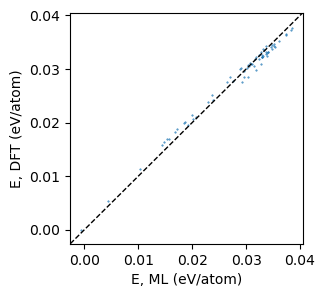

In [17]:
fig, ax = plt.subplots(figsize=(3., 3.))

ref = comparison.loc[comparison['dft'].argmin()]
ax.scatter(comparison['ml'] - ref['dft'], comparison['dft'] - ref['dft'], s=0.2)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

ax.set_xlabel('E, ML (eV/atom)')
ax.set_ylabel('E, DFT (eV/atom)')

## Run a Few Training Sets
Enough to show that we can get better

In [18]:
loader = DataLoader(
    [AtomicData.from_config(c, z_table=calc.z_table, cutoff=calc.r_max) for c in configs],
    batch_size=8,
    shuffle=True,
    drop_last=True,
)

Set some weights as eligible for training

In [19]:
for p in model.readouts.parameters():
    p.requires_grad = True

Define the loss function and optimizer

In [20]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = WeightedEnergyForcesLoss(energy_weight=1.0, forces_weight=100.)

Define the trainer and evaluators

In [21]:
def train_step(engine, batch):
    """Borrowed from the training step used inside MACE"""
    model.train()
    opt.zero_grad()
    batch = batch.to('cuda')
    y = model(
        batch,
        training=True,
        compute_force=True,
        compute_virials=False,
        compute_stress=False,
    )
    loss = criterion(pred=y, ref=batch)
    loss.backward()
    opt.step()
    return loss.item()

In [22]:
val_metrics = {
    "loss": Loss(criterion)
}
trainer = Engine(train_step)

In [23]:
trainer.run(loader, max_epochs=64)

State:
	iteration: 512
	epoch: 64
	epoch_length: 8
	max_epochs: 64
	output: 1.3115605115890503
	batch: <class 'mace.tools.torch_geometric.batch.Batch'>
	metrics: <class 'dict'>
	dataloader: <class 'mace.tools.torch_geometric.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [24]:
comparison['ml-next'] = [
    calc.get_potential_energy(atoms) / len(atoms) for atoms 
    in tqdm(iread(train_file))
]

66it [00:01, 45.16it/s]


In [25]:
comparison['ml-forces-next'] = [
    calc.get_forces(atoms) for atoms 
    in tqdm(iread(train_file))
]


66it [00:01, 46.09it/s]


In [26]:
comparison['force_rmse-next'] = np.sqrt([np.power(x - y, 2).mean() for x, y in 
                                    zip(comparison['dft-forces'], comparison['ml-forces-next'])])

In [27]:
comparison[['force_rmse', 'force_rmse-next']].describe()

,force_rmse,force_rmse-next
count,66.000000,66.000000
mean,0.120166,0.116996
std,0.019613,0.020249
min,0.072876,0.067872
25%,0.108996,0.105947
50%,0.117779,0.115000
75%,0.136721,0.134266
max,0.154518,0.152211


ml 0.0008460289928014694
ml-next 0.000853703788254906


Text(0, 0.5, 'E, DFT (eV)')

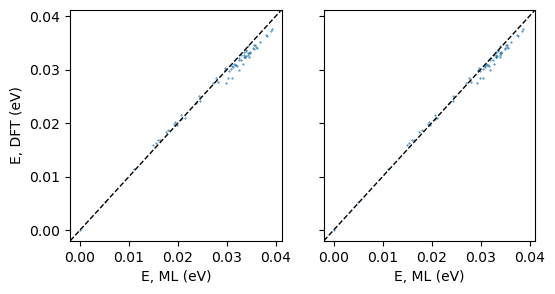

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(6., 3.), sharey=True, sharex=True)

ref = comparison.loc[comparison['dft'].argmin()]
for ax, c in zip(axs, ['ml', 'ml-next']):
    mae = (comparison['dft'] - comparison[c]).abs().mean()
    print(c, mae)
    
    ax.scatter(comparison[c] - ref[c], comparison['dft'] - ref['dft'], s=0.2)

    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

    ax.set_xlabel('E, ML (eV)')
axs[0].set_ylabel('E, DFT (eV)')

The energy is getting worse while our predictions of forces get better. Changes are happening and we've got work to do to make them work as well as we need